In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import skill_metrics as sm

# Load observational dataset
obs_shdr_path = "/Volumes/Thalassa/CORA_SHDR_rg/"
obs_files = sorted(glob.glob(obs_shdr_path + '*.nc'))
obs_shdr = xr.open_mfdataset(obs_files)  # Open all NetCDF files

# Compute climatological mean for observations
obs_shdr_clim = obs_shdr.groupby('time.month').mean(dim='time')

# Load CMIP6 ensemble climatology dataset
cmip6_shdr_ens_all = xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/shdr.nc")

# Extract MLD (D1) for observations and models
obs_mld = obs_shdr_clim.sel(param='D1').shdr
cmip6_mld = cmip6_shdr_ens_all.sel(param='D1').shdr  # Already climatological

In [33]:
import xarray as xr
import numpy as np
import pprint

# Define regions correctly
regions = {
    # Pacific Ocean
    "North Pacific": {"lat": slice(20, 60), "lon": (slice(120, 180), slice(180, 280))},
    "Tropical Pacific": {"lat": slice(-20, 20), "lon": (slice(120, 180), slice(180, 280))},
    "South Pacific": {"lat": slice(-45, -20), "lon": (slice(120, 180), slice(180, 280))},

    # Atlantic Ocean (Corrected, as per your confirmation)
    "North Atlantic": {"lat": slice(20, 60), "lon": (slice(280, 360), slice(0, 20))},
    "Tropical Atlantic": {"lat": slice(-20, 20), "lon": (slice(280, 360), slice(0, 20))},
    "South Atlantic": {"lat": slice(-45, -20), "lon": (slice(280, 360), slice(0, 20))},

    # Indian Ocean
    "Tropical Indian": {"lat": slice(-20, 20), "lon": slice(40, 120)},
    "South Indian": {"lat": slice(-45, -20), "lon": slice(40, 120)},

    # Southern Ocean (Full Longitude Coverage)
    "Southern Ocean": {"lat": slice(-90, -45), "lon": slice(0, 360)}
}


SUBPLOTS_DATA = []
rows, cols = 3, 3  # Define grid structure (adjust if needed)
i, j = 0, 0  # Initialize subplot indices

for region, bounds in regions.items():
    
    # Extract observed MLD for the region
    obs_mld_region = xr.concat([
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    # Extract CMIP6 MLD for the region
    cmip6_mld_region = xr.concat([
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    # Compute observed Taylor statistics
    taylor_stats_obs = sm.taylor_statistics(obs_mld_region.values, obs_mld_region.values, 'data')

    # Initialize models dictionary
    models = {}

    # Loop over models
    for m in range(len(cmip6_mld_region.model)):

        # Extract model name as a string
        model_name = cmip6_mld_region.model.isel(model=m).item()
        
        # Compute Taylor statistics
        taylor_stats = sm.taylor_statistics(cmip6_mld_region.isel(model=m).values, obs_mld_region.values, 'data')

        # Store in models dictionary
        models[f"{model_name}"] = (
            taylor_stats['sdev'][1],
            taylor_stats['crmsd'][1],
            taylor_stats['ccoef'][1]
        )

    # Define subplot title dynamically (like "1 hour lead time")
    title_label = ["(a)", "(b)", "(c)", "(d)", "(e)"]  # Customize as needed
    title = f"{title_label[len(SUBPLOTS_DATA) % len(title_label)]} {region}"

    # Append subplot info for this region
    SUBPLOTS_DATA.append(
        {   "axis_idx": (i, j),
            "title": title,
            "y_label": True if j == 0 else False,  # Left-most column gets y-label
            "x_label": True if i == rows - 1 else False,  # Bottom row gets x-label
            "observed": (
                taylor_stats_obs['sdev'][0], 
                taylor_stats_obs['crmsd'][0], 
                taylor_stats_obs['ccoef'][0]
            ),
            "modeled": models
        }
    )

    # Update subplot grid position
    j += 1
    if j >= cols:  # Move to the next row after filling all columns
        j = 0
        i += 1

# Display the final structure



TypeError: 'slice' object is not subscriptable

In [3]:
# Create labels

import matplotlib.pyplot as plt

model_names = ['Obs'] + list(cmip6_mld_region.model.values)

# Define marker styles (at least 22 unique ones)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', '*', 'p', 'X', 'H', 'h', '+', 'x', '|', '_', '1', '2', '3', '4', 'P', '.','8']

# Define a list of colors for diversity
colors = plt.cm.get_cmap("tab20", 23)  # Using a colormap to generate 22 colors

MARKERS = {}
for i, model in enumerate(model_names):
    MARKERS[model] = {
        "marker": marker_styles[i % len(marker_styles)],  # Cycle through available markers
        "color_edge": "#000000",  # Edge color (black for contrast)
        "color_face": plt.cm.tab20(i / len(model_names)),  # Unique face color per model
        "markersize": 9 if i > 0 else 12  # Larger size for observation
    }


FONT_FAMILY = 'Times New Roman'
FONT_SIZE = 9

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}


/var/folders/1w/tylnjhqj10s0yzmzt5ykpls80000gn/T/ipykernel_1032/3139958060.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", 23)  # Using a colormap to generate 22 colors


[20. 40. 60.]
[2. 4.]
[20. 40.]


/var/folders/1w/tylnjhqj10s0yzmzt5ykpls80000gn/T/ipykernel_1032/1565624897.py:138: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


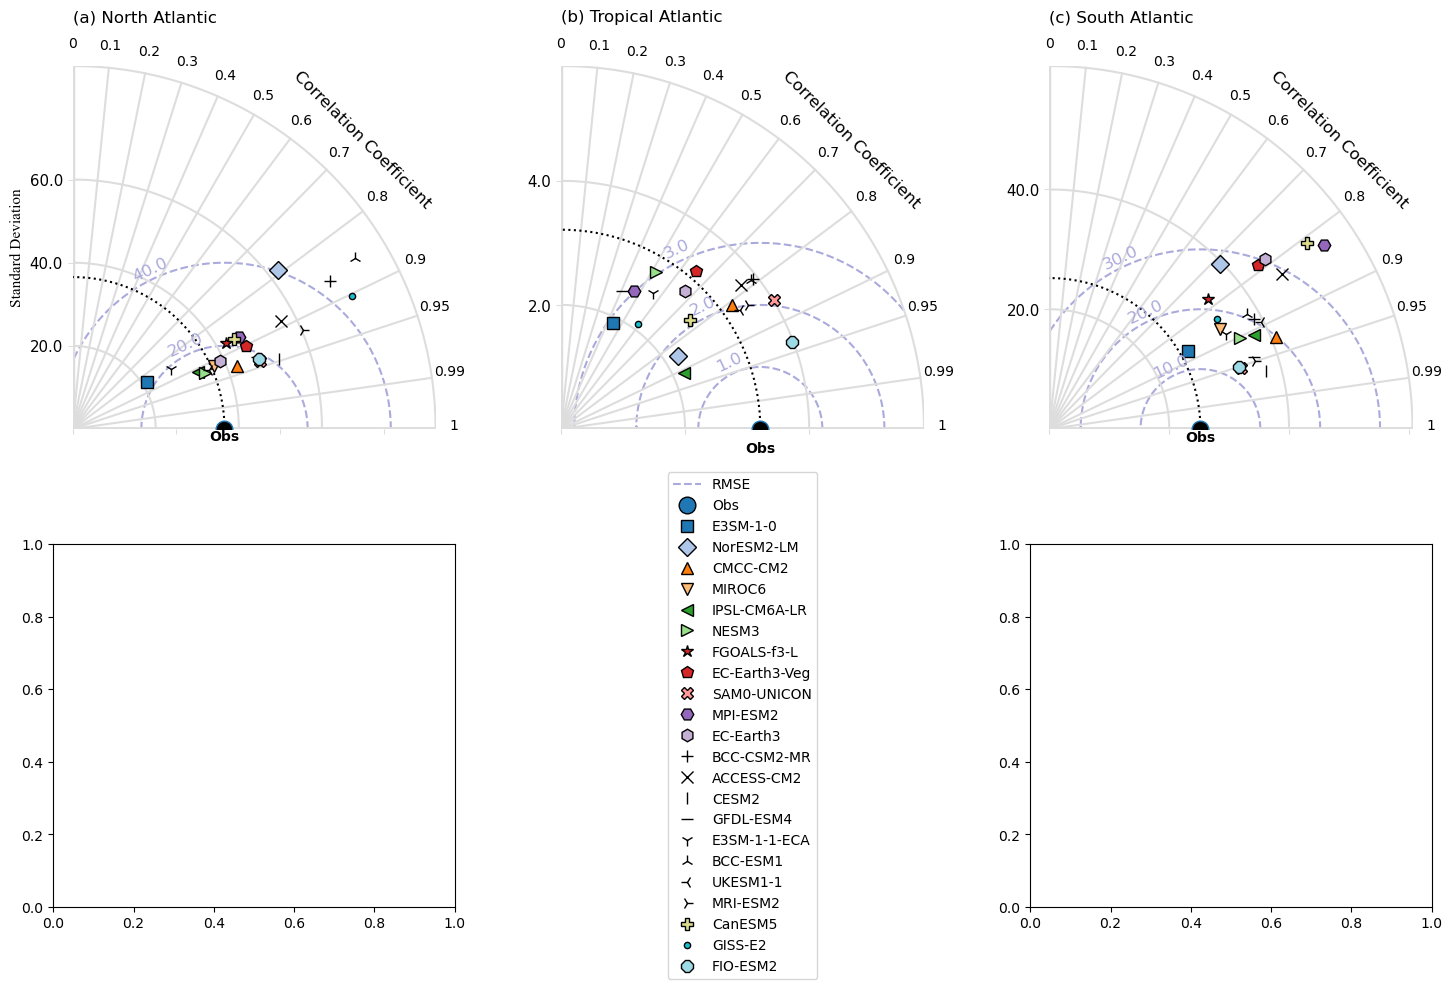

In [32]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

def calculate_rmse_ticks(max_rmse):
    if max_rmse > 40:
        step = 20
    elif max_rmse > 20:
        step = 10
    elif max_rmse > 5:
        step = 2
    else:
        step = 1
    return np.arange(0, max_rmse, step)[1::]

LEGEND_SUBPLOT = (1, 1)

# Create figure and subplots grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

for subplot_data in SUBPLOTS_DATA:
    
    # Get subplot object and ensure it will be a square
    ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
    ax.set(adjustable='box', aspect='equal')

    # Extract observed Taylor statistics
    stdev_obs, crmsd_obs, ccoef_obs = subplot_data["observed"]

    max_stdev = max([stdev_obs] + [m[0] for m in subplot_data["modeled"].values()])
    max_rmse = max([crmsd_obs] + [m[1] for m in subplot_data["modeled"].values()])
    rmse_ticks = calculate_rmse_ticks(max_rmse)
    stdev_ticks = calculate_rmse_ticks(max_stdev)

    # Plot observed point on Taylor Diagram
    sm.taylor_diagram(
        ax,
        np.asarray((stdev_obs, stdev_obs)), 
        np.asarray((crmsd_obs, crmsd_obs)), 
        np.asarray((ccoef_obs, ccoef_obs)),
        markercolors={
            "face": MARKERS["Obs"]["color_edge"],
            "edge": MARKERS["Obs"]["color_face"]
        },
        markersize=MARKERS["Obs"]["markersize"],
        markersymbol=MARKERS["Obs"]["marker"],
        styleOBS=':',
        colOBS=MARKERS["Obs"]["color_edge"],
        alpha=1.0,
        titleSTD='off',
        titleRMS='off',
        showlabelsRMS='on',
        tickRMS=rmse_ticks,
        colRMS=STYLES_RMS['color'],
        tickRMSangle=115,
        tickSTD=stdev_ticks,
        styleRMS=STYLES_RMS['linestyle'],
        colscor=COLS_COR,
        colsstd=COLS_STD,
        styleCOR='-',
        styleSTD='-',
        colframe='#DDDDDD',
        labelweight='normal',
        titlecorshape='linear',
        axisMax=max_stdev * 1.1  # Set the maximum limit for the radial contours
        )


    # Label the observed point
    ax.text(stdev_obs, -0.2, "Obs", verticalalignment="top",
            horizontalalignment="center", 
            fontsize=FONT_SIZE + 1, fontweight="bold")

    # Loop through modeled values and overlay markers
    for model_id, (stdev, crmsd, ccoef) in subplot_data["modeled"].items():
        marker = MARKERS[model_id]  # Get model-specific marker

        sm.taylor_diagram(
            ax,
            np.asarray((stdev, stdev)),
            np.asarray((crmsd, crmsd)),
            np.asarray((ccoef, ccoef)),
            markersymbol=marker["marker"],
            markercolors={
                "face": marker["color_face"],
                "edge": marker["color_edge"]
            },
            markersize=marker["markersize"],
            alpha=1.0,
            overlay='on',
            styleCOR='-',
            styleSTD='-',
        )

    # Set subplot title
    ax.set_title(subplot_data["title"], loc="left", y=1.1)
    ax.set_yticks(stdev_ticks)

    # Set y-labels (only for leftmost subplots)
    if subplot_data["y_label"]:
        ax.set_ylabel("Standard Deviation", fontfamily=FONT_FAMILY,
                      fontsize=FONT_SIZE + 2)

    # Set x-labels or hide tick labels
    if subplot_data["x_label"]:
        ax.set_xlabel("Standard Deviation", fontfamily=FONT_FAMILY,
                      fontsize=FONT_SIZE + 2)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), color=ax.get_facecolor())
    ax.set_yticks(stdev_ticks)
    ax.set_yticklabels(stdev_ticks)
    print(stdev_ticks)
# Create a legend in the last subplot
ax = axs[LEGEND_SUBPLOT[0]][LEGEND_SUBPLOT[1]]
ax.axis('off')

# Build legend handles    
legend_handles = []
legend_handles.append(mlines.Line2D([], [],
                                    color=STYLES_RMS['color'],
                                    linestyle=STYLES_RMS['linestyle'],
                                    label="RMSE"))

for marker_label, marker_desc in MARKERS.items():
    marker = mlines.Line2D([], [], 
                           marker=marker_desc["marker"],
                           markersize=marker_desc["markersize"],
                           markerfacecolor=marker_desc["color_face"],
                           markeredgecolor=marker_desc["color_edge"],
                           linestyle='None',
                           label=marker_label)
    legend_handles.append(marker)

# Create the legend
ax.legend(handles=legend_handles, loc="center")    

# Adjust layout to avoid overlapping
plt.tight_layout()



# Show the plot
plt.show()

In [13]:
stdev_ticks

array([20., 40., 60.])

None


['Non-Dimensional Observation',
 array(['E3SM-1-0', 'NorESM2-LM', 'CMCC-CM2', 'MIROC6', 'IPSL-CM6A-LR',
        'NESM3', 'FGOALS-f3-L', 'EC-Earth3-Veg', 'SAM0-UNICON', 'MPI-ESM2',
        'EC-Earth3', 'BCC-CSM2-MR', 'ACCESS-CM2', 'CESM2', 'GFDL-ESM4',
        'E3SM-1-1-ECA', 'BCC-ESM1', 'UKESM1-1', 'MRI-ESM2', 'CanESM5',
        'GISS-E2', 'FIO-ESM2'], dtype='<U13')]

In [14]:

taylor_stats1 = sm.taylor_statistics(cmip6_mld_region.isel(model=1).values,obs_mld_region.values,'data')

In [15]:
taylor_stats1 

{'ccoef': array([1.        , 0.79116794]),
 'crmsd': [0.0, np.float64(40.42803316994444)],
 'sdev': [np.float64(36.54614921491551), np.float64(62.60141527389671)]}

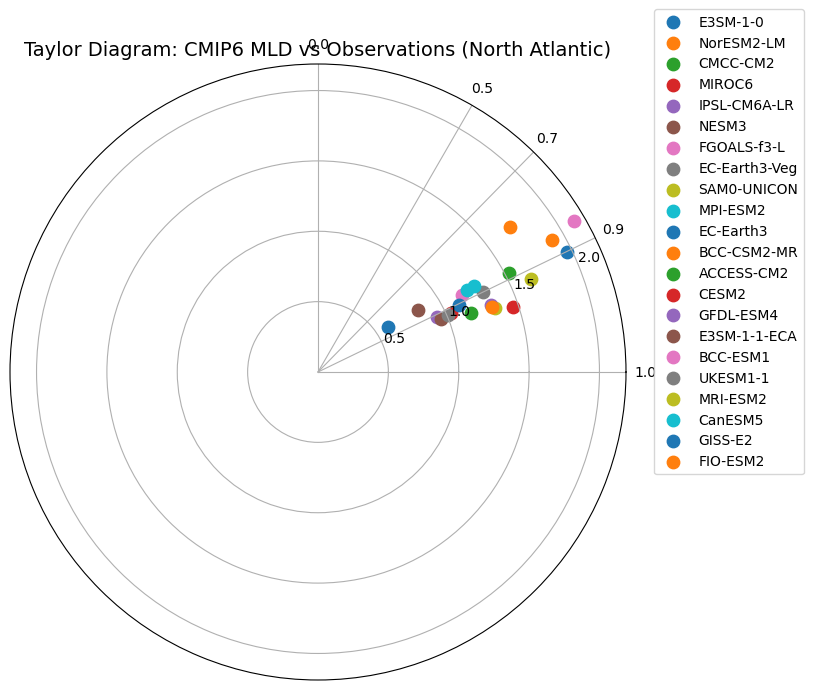

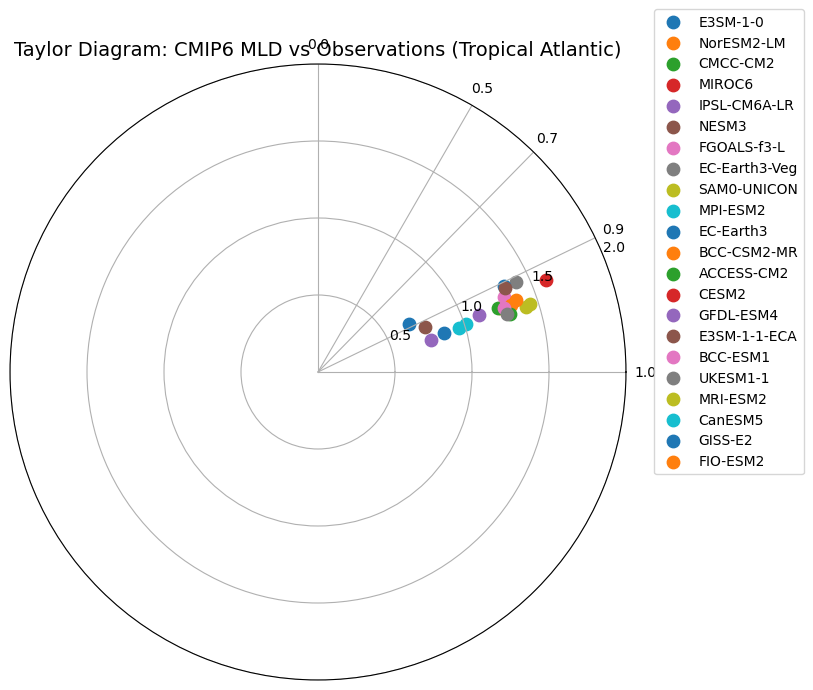

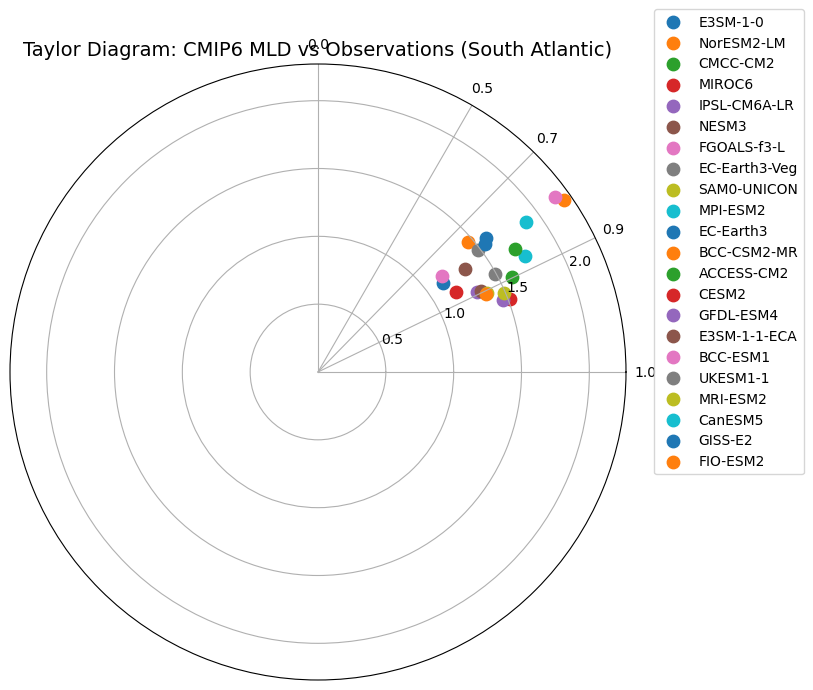

In [ ]:
# Define regional boundaries with longitude adjustments (0–365 range)
regions = {
    "North Atlantic": {"lat": slice(20, 60), "lon": (slice(280, 360), slice(0, 20))}}

#    "Tropical Atlantic": {"lat": slice(-20, 0), "lon": (slice(280, 360), slice(0, 20))},
#    "South Atlantic": {"lat": slice(-60, -20), "lon": (slice(280, 360), slice(0, 20))},


# Store results for each region
results = {}

for region, bounds in regions.items():
    # Merge longitude selections
    obs_mld_region = xr.concat([
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    cmip6_mld_region = xr.concat([
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    # Compute Taylor metrics for each model
    std_dev_models = []
    correlation_models = []
    
    for model in cmip6_mld_region.model:
        model_mld = cmip6_mld_region.sel(model=model)

        # Standard deviation (normalized)
        std_dev_model = np.std(model_mld)
        std_dev_norm = std_dev_model / np.std(obs_mld_region)
        std_dev_models.append(std_dev_norm)

        # Correlation
        correlation = np.corrcoef(model_mld, obs_mld_region)[0, 1]
        correlation_models.append(correlation)

    # Convert lists to arrays
    std_dev_models = np.array(std_dev_models)
    correlation_models = np.array(correlation_models)
    
    # Compute RMSE
    rmsd_models = np.sqrt(2 * (1 - correlation_models))

    # Store results
    results[region] = {
        "std_dev_models": std_dev_models,
        "correlation_models": correlation_models,
        "rmsd_models": rmsd_models,
        "models": cmip6_mld_region.model.values
    }

# Function to plot a custom Taylor diagram
def plot_taylor_diagram(std_devs, corrs, models, region):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Convert correlation to angles
    angles = np.arccos(corrs)
    
    # Plot each model
    for i, model in enumerate(models):
        ax.scatter(angles[i], std_devs[i], label=model, s=80)

    # Format plot
    ax.set_xticks(np.arccos([1, 0.9, 0.7, 0.5, 0]))  # Set correlation labels
    ax.set_xticklabels(["1.0", "0.9", "0.7", "0.5", "0.0"])
    ax.set_yticks([0.5, 1.0, 1.5, 2.0])  # Standard deviation
    ax.set_yticklabels(["0.5", "1.0", "1.5", "2.0"])
    ax.set_title(f"Taylor Diagram: CMIP6 MLD vs Observations ({region})", fontsize=14)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Generate Taylor diagrams for each region
for region, data in results.items():
    plot_taylor_diagram(data["std_dev_models"], data["correlation_models"], data["models"], region)